In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from glob import glob
import torch as t
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import torch.nn.functional as F
import json
from torchvision.models.mobilenet import mobilenet_v2
from torchvision.models.resnet import resnet50, resnet34,resnet18
from torchsummary import summary
import random
from torchvision.models.mobilenet import MobileNetV2

In [2]:
#下载街景字符识别的数据集，并且解压
import pandas as pd
import os
import requests
import zipfile
import shutil

links = pd.read_csv('/root/data/mchar_data_list_0515.csv')#修改成你电脑对应的路径
dir_name = 'NDataset'
mypath = '/root/data/'
if not os.path.exists(mypath + dir_name):
    os.mkdir(mypath + dir_name)
for i,link in enumerate(links['link']):
    file_name = links['file'][i]
    print(file_name, '\t', link)
    file_name = mypath + dir_name + '/' + file_name
    if not os.path.exists(file_name):
        response = requests.get(link, stream=True)
        with open( file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
zip_list = ['mchar_train', 'mchar_test_a', 'mchar_val']
for little_zip in zip_list:
    if not os.path.exists(mypath + dir_name + '/' + little_zip):
        zip_file = zipfile.ZipFile(mypath + dir_name + '/' + little_zip + '.zip', 'r')
        zip_file.extractall(path = mypath + dir_name )
if os.path.exists(mypath + dir_name + '/' + '__MACOSX'):
    shutil.rmtree(mypath + dir_name + '/' + '__MACOSX')

mchar_train.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.zip
mchar_train.json 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.json
mchar_val.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.zip
mchar_val.json 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.json
mchar_test_a.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_test_a.zip
mchar_sample_submit_A.csv 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_sample_submit_A.csv


In [3]:
#目录路径
data_dir = {
    'train_data': '/root/data/NDataset/mchar_train/',
    'val_data': '/root/data/NDataset/mchar_val/',
    'test_data': '/root/data/NDataset/mchar_test_a/',
    'train_label': '/root/data/NDataset/mchar_train.json',
    'val_label': '/root/data/NDataset/mchar_val.json',
    'submit_file': '/root/data/NDataset/mchar_sample_submit_A.csv'
}

In [4]:
#统计train,val,test数据集的个数
def data_summary():
  train_list = glob(data_dir['train_data']+'*.png')
  test_list = glob(data_dir['test_data']+'*.png')
  val_list = glob(data_dir['val_data']+'*.png')
  print('train image counts: %d'%len(train_list))
  print('val image counts: %d'%len(val_list))
  print('test image counts: %d'%len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [5]:
#看train数据集第一张的信息，长宽高等
def look_train_json():
  with open(data_dir['train_label'], 'r', encoding='utf-8') as f:
    content = f.read()

  content = json.loads(content)

  print(content['000000.png'])

look_train_json()

{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}


In [6]:
#看需要输出文件的信息
def look_submit():
  df = pd.read_csv(data_dir['submit_file'], sep=',')
  print(df.head(5))

look_submit()

    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


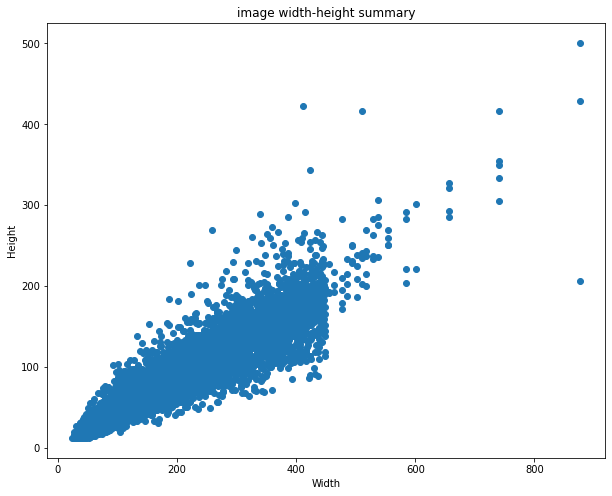

In [7]:
#统计图片的大小
def img_size_summary():
  sizes = []

  for img in glob(data_dir['train_data']+'*.png'):
    img = Image.open(img)

    sizes.append(img.size)

  sizes = np.array(sizes)

  plt.figure(figsize=(10, 8))
  plt.scatter(sizes[:, 0], sizes[:, 1])
  plt.xlabel('Width')
  plt.ylabel('Height')

  plt.title('image width-height summary')
  plt.show()

img_size_summary()

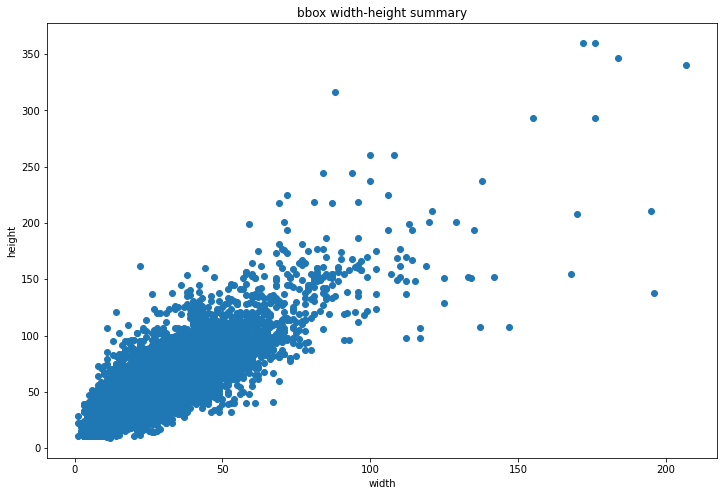

In [8]:
#统计bbox的大小
def bbox_summary():
  marks = json.loads(open(data_dir['train_label'], 'r').read())
  bboxes = []

  for img, mark in marks.items():
    for i in range(len(mark['label'])):
      bboxes.append([mark['left'][i], mark['top'][i], mark['width'][i], mark['height'][i]])

  bboxes = np.array(bboxes)

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(bboxes[:, 2], bboxes[:, 3])
  ax.set_title('bbox width-height summary')
  ax.set_xlabel('width')
  ax.set_ylabel('height')
  plt.show()

bbox_summary()

In [9]:
#统计图片分别含有数字的个数
def label_summary():
    marks = json.load(open(data_dir['train_label'], 'r'))

    dicts = {}
    for img, mark in marks.items():
        if len(mark['label']) not in dicts:
            dicts[len(mark['label'])] = 0
        dicts[len(mark['label'])] += 1

    dicts = sorted(dicts.items(), key=lambda x: x[0])
    for k, v in dicts:
        print('%d个数字的图片数目: %d' % (k, v))


label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


In [10]:
#超参数设定
class Config:

  batch_size = 64

  lr = 1e-4

  momentum = 0.9

  weights_decay = 1e-4

  class_num = 11

  eval_interval = 1

  checkpoint_interval = 1

  print_interval = 50

  checkpoints = '/root/data/NDataset/checkpoints/'#这个需要自己创建一个文件夹用来储存权重

  pretrained = '/root/data/NDataset/checkpoints/epoch-mobeilenet50-65-bn-acc-61.18.pth' #'/content/NDataset/checkpionts/epoch-mobeilenet-91-bn-acc-72.23.pth'

  start_epoch = 52

  epoches = 80

  smooth = 0.1

  erase_prob = 0.5

config = Config()
config.start_epoch

52

In [11]:
class DigitsDataset(Dataset):
    """

    DigitsDataset

    Params:
      data_dir(string): data directory

      label_path(string): label path

      aug(bool): wheather do image augmentation, default: True
    """

    def __init__(self, mode='train', size=(128, 256), aug=True):
        super(DigitsDataset, self).__init__()

        self.aug = aug
        self.size = size
        self.mode = mode
        self.width = 224
        # self.weights = np.array(list(label__nums_summary().values()))
        # self.weights = (np.sum(self.weights) - self.weights) / self.weights
        # self.weights = t.from_numpy(self.weights.to_list().append(1)).float()
        self.batch_count = 0
        if mode == 'test':
            self.imgs = glob(data_dir['test_data'] + '*.png')
            self.labels = None
        else:
            labels = json.load(open(data_dir['%s_label' % mode], 'r'))

            imgs = glob(data_dir['%s_data' % mode] + '*.png')
            self.imgs = [(img, labels[os.path.split(img)[-1]]) for img in imgs \
                         if os.path.split(img)[-1] in labels]

    def __getitem__(self, idx):
        if self.mode != 'test':
            img, label = self.imgs[idx]
        else:
            img = self.imgs[idx]
            label = None
        img = Image.open(img)
        trans0 = [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        min_size = self.size[0] if (img.size[1] / self.size[0]) < ((img.size[0] / self.size[1])) else self.size[1]
        trans1 = [
            transforms.Resize(128),
            transforms.CenterCrop((128, self.width))
        ]
        if self.aug:
            trans1.extend([
                transforms.ColorJitter(0.1, 0.1, 0.1),
                transforms.RandomGrayscale(0.1),
                transforms.RandomAffine(15, translate=(0.05, 0.1), shear=5)
            ])
        trans1.extend(trans0)
        if self.mode != 'test':
            return transforms.Compose(trans1)(img), t.tensor(
                label['label'][:4] + (4 - len(label['label'])) * [10]).long()
        else:
            # trans1.append(transforms.RandomErasing(scale=(0.02, 0.1)))
            return transforms.Compose(trans1)(img), self.imgs[idx]

    def __len__(self):
        return len(self.imgs)

    def collect_fn(self, batch):
        imgs, labels = zip(*batch)
        if self.mode == 'train':
            if self.batch_count > 0 and self.batch_count % 10 == 0:
                self.width = random.choice(range(224, 256, 16))

        self.batch_count += 1
        return t.stack(imgs).float(), t.stack(labels)

In [12]:
class DigitsMobilenet(nn.Module):

  def __init__(self, class_num=11):
    super(DigitsMobilenet, self).__init__()

    self.net = mobilenet_v2(pretrained=True).features
    # self.net.classifier = nn.Identity()
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.bn = nn.BatchNorm1d(1280)
    self.fc1 = nn.Linear(1280, class_num)
    self.fc2 = nn.Linear(1280, class_num)
    self.fc3 = nn.Linear(1280, class_num)
    self.fc4 = nn.Linear(1280, class_num)
    # self.fc5 = nn.Linear(1280, class_num)

  def forward(self, img):
    features = self.avgpool(self.net(img)).view(-1, 1280)
    features = self.bn(features)

    fc1 = self.fc1(features)
    fc2 = self.fc2(features)
    fc3 = self.fc3(features)
    fc4 = self.fc4(features)
    # fc5 = self.fc5(features)

    return fc1, fc2, fc3, fc4


class DigitsResnet18(nn.Module):

  def __init__(self, class_num=11):
    super(DigitsResnet18, self).__init__()
    self.net = resnet18(pretrained=True)
    self.net.fc = nn.Identity()
    # self.net = nn.Sequential(
    #     MobileNetV2(num_classes=class_num).features,
    #     nn.AdaptiveAvgPool2d((1, 1))
    # )
    self.bn = nn.BatchNorm1d(512)
    self.fc1 = nn.Linear(512, class_num)
    self.fc2 = nn.Linear(512, class_num)
    self.fc3 = nn.Linear(512, class_num)
    self.fc4 = nn.Linear(512, class_num)
    # self.fc5 = nn.Linear(512, class_num)

  def forward(self, img):
    features = self.net(img).squeeze()

    fc1 = self.fc1(features)
    fc2 = self.fc2(features)
    fc3 = self.fc3(features)
    fc4 = self.fc4(features)
    # fc5 = self.fc5(features)

    return fc1, fc2, fc3, fc4


class DigitsResnet50(nn.Module):
    def __init__(self, class_num=11):
        super(DigitsResnet50, self).__init__()

        # resnet18
        self.net = resnet50(pretrained=True)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.net = nn.Sequential(*list(self.net.children())[:-1])  # 去除最后一个fc layer
        self.cnn = self.net

        self.hd_fc1 = nn.Linear(2048, 128)  #512改成2048
        self.hd_fc2 = nn.Linear(2048, 128)
        self.hd_fc3 = nn.Linear(2048, 128)
        self.hd_fc4 = nn.Linear(2048, 128)
        # self.hd_fc5 = nn.Linear(512, 128)
        self.dropout_1 = nn.Dropout(0.5)
        self.dropout_2 = nn.Dropout(0.5)
        self.dropout_3 = nn.Dropout(0.5)
        self.dropout_4 = nn.Dropout(0.5)
        # self.dropout_5 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128, 11)
        self.fc2 = nn.Linear(128, 11)
        self.fc3 = nn.Linear(128, 11)
        self.fc4 = nn.Linear(128, 11)
        # self.fc5 = nn.Linear(128, 11)

    def forward(self, img):
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        # feat = self.net(img).squeeze()

        feat1 = self.hd_fc1(feat)
        feat2 = self.hd_fc2(feat)
        feat3 = self.hd_fc3(feat)
        feat4 = self.hd_fc4(feat)
        # feat5 = self.hd_fc5(feat)
        feat1 = self.dropout_1(feat1)
        feat2 = self.dropout_2(feat2)
        feat3 = self.dropout_3(feat3)
        feat4 = self.dropout_4(feat4)
        # feat5 = self.dropout_5(feat5)

        c1 = self.fc1(feat1)
        c2 = self.fc2(feat2)
        c3 = self.fc3(feat3)
        c4 = self.fc4(feat4)
        # c5 = self.fc5(feat5)

        return c1, c2, c3, c4

In [13]:
net = resnet18(pretrained=True)
net.to(t.device('cuda'))
summary(net, input_size=(3, 64, 128), batch_size=config.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 64]           9,408
       BatchNorm2d-2           [64, 64, 32, 64]             128
              ReLU-3           [64, 64, 32, 64]               0
         MaxPool2d-4           [64, 64, 16, 32]               0
            Conv2d-5           [64, 64, 16, 32]          36,864
       BatchNorm2d-6           [64, 64, 16, 32]             128
              ReLU-7           [64, 64, 16, 32]               0
            Conv2d-8           [64, 64, 16, 32]          36,864
       BatchNorm2d-9           [64, 64, 16, 32]             128
             ReLU-10           [64, 64, 16, 32]               0
       BasicBlock-11           [64, 64, 16, 32]               0
           Conv2d-12           [64, 64, 16, 32]          36,864
      BatchNorm2d-13           [64, 64, 16, 32]             128
             ReLU-14           [64, 64,

In [14]:
net = DigitsResnet18()
print(net)

DigitsResnet18(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [15]:
# 查看网络结构
net.to(t.device('cuda'))
summary(net, input_size=(3, 64, 128), batch_size=config.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 64]           9,408
       BatchNorm2d-2           [64, 64, 32, 64]             128
              ReLU-3           [64, 64, 32, 64]               0
         MaxPool2d-4           [64, 64, 16, 32]               0
            Conv2d-5           [64, 64, 16, 32]          36,864
       BatchNorm2d-6           [64, 64, 16, 32]             128
              ReLU-7           [64, 64, 16, 32]               0
            Conv2d-8           [64, 64, 16, 32]          36,864
       BatchNorm2d-9           [64, 64, 16, 32]             128
             ReLU-10           [64, 64, 16, 32]               0
       BasicBlock-11           [64, 64, 16, 32]               0
           Conv2d-12           [64, 64, 16, 32]          36,864
      BatchNorm2d-13           [64, 64, 16, 32]             128
             ReLU-14           [64, 64,

In [13]:
# ----------------------------------- LabelSmoothEntropy ----------------------------------- #
class LabelSmoothEntropy(nn.Module):
    def __init__(self, smooth=0.1, class_weights=None, size_average='mean'):
        super(LabelSmoothEntropy, self).__init__()
        self.size_average = size_average
        self.smooth = smooth

        self.class_weights = class_weights

    def forward(self, preds, targets):

        lb_pos, lb_neg = 1 - self.smooth, self.smooth / (preds.shape[0] - 1)

        smoothed_lb = t.zeros_like(preds).fill_(lb_neg).scatter_(1, targets[:, None], lb_pos)

        log_soft = F.log_softmax(preds, dim=1)

        if self.class_weights is not None:
            loss = -log_soft * smoothed_lb * self.class_weights[None, :]

        else:
            loss = -log_soft * smoothed_lb

        loss = loss.sum(1)
        if self.size_average == 'mean':
            return loss.mean()

        elif self.size_average == 'sum':
            return loss.sum()
        else:
            raise NotImplementedError

In [14]:
# ----------------------------------- SnapShot ----------------------------------- #
class SnapShotBuilder():
    """

    Params:
      n_epoch(integer): total training epoches

      n_snap(integer): parameters of model saved times

    """

    def __init__(self, n_epoch, n_snap):
        self.n_epoch = n_epoch

        self.n_snap = n_snap

        pass

    def __call__(self):
        pass

    def _scheduler(self):
        pass

In [15]:
class Trainer:

    def __init__(self, val=True):

        self.device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

        self.train_set = DigitsDataset(mode='train')
        self.train_loader = DataLoader(self.train_set, batch_size=config.batch_size, shuffle=True, num_workers=8,
                                       pin_memory=True, \
                                       drop_last=True, collate_fn=self.train_set.collect_fn)

        if val:
            self.val_loader = DataLoader(DigitsDataset(mode='val', aug=True), batch_size=config.batch_size, \
                                         num_workers=8, pin_memory=True, drop_last=False)
        else:
            self.val_loader = None

#可以切换使用resnet或者Mobilenet
        self.model = DigitsMobilenet(config.class_num).to(self.device)
        # self.model = DigitsResnet50(config.class_num).to(self.device)

        self.criterion = LabelSmoothEntropy().to(self.device)

#optimizer可选择SGD或者Adam
        # self.optimizer = SGD(self.model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weights_decay, nesterov=True)
        from torch.optim import Adam
        # self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        self.optimizer = Adam(self.model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0,
                              amsgrad=False)
#学习率调整
        # self.lr_scheduler = CosineAnnealingWarmRestarts(self.optimizer, 10, 2, eta_min=10e-5),eta_min=10e-4,10e-5
        self.lr_scheduler = CosineAnnealingWarmRestarts(self.optimizer, T_0=10, T_mult=2, eta_min=0)
        # self.lr_scheduler = (self.optimizer, [10, 20, 30], 0.5)
        self.best_acc = 0

# #是否载入预训练模型
#         if config.pretrained is not None:
#             self.load_model(config.pretrained)
#             # print('Load model from %s'%config.pretrained)
#             if self.val_loader is not None:
#                 acc = self.eval()
#             self.best_acc = acc
#             print('Load model from %s, Eval Acc: %.2f' % (config.pretrained, acc * 100))

    def train(self):
        for epoch in range(config.start_epoch, config.epoches):
            acc = self.train_epoch(epoch)
            if (epoch + 1) % config.eval_interval == 0:
                print('Start Evaluation')
                if self.val_loader is not None:
                    acc = self.eval()
#保存最优模型
                if acc > self.best_acc:
                    os.makedirs(config.checkpoints, exist_ok=True)
                    save_path = config.checkpoints + 'epoch-resnet50-%d-bn-acc-%.2f.pth' % (epoch + 1, acc * 100)
                    self.save_model(save_path)
                    print('%s saved successfully...' % save_path)
                    self.best_acc = acc

    def train_epoch(self, epoch):
        total_loss = 0
        corrects = 0
        tbar = tqdm(self.train_loader)
        self.model.train()
        for i, (img, label) in enumerate(tbar):
            # print(img.shape)
            img = img.to(self.device)
            label = label.to(self.device)
            self.optimizer.zero_grad()
            pred = self.model(img)
            loss = self.criterion(pred[0], label[:, 0]) + \
                   self.criterion(pred[1], label[:, 1]) + \
                   self.criterion(pred[2], label[:, 2]) + \
                   self.criterion(pred[3], label[:, 3]) \
                # + self.criterion(pred[4], label[:, 4])
            total_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            temp = t.stack([ \
                pred[0].argmax(1) == label[:, 0], \
                pred[1].argmax(1) == label[:, 1], \
                pred[2].argmax(1) == label[:, 2], \
                pred[3].argmax(1) == label[:, 3], ], dim=1)

            corrects += t.all(temp, dim=1).sum().item()
            tbar.set_description(
                'loss: %.3f, acc: %.3f' % (loss / (i + 1), corrects * 100 / ((i + 1) * config.batch_size)))
            if (i + 1) % config.print_interval == 0:
                self.lr_scheduler.step()

        return corrects * 100 / ((i + 1) * config.batch_size)

    def eval(self):
        self.model.eval()
        corrects = 0
        with t.no_grad():
            tbar = tqdm(self.val_loader)
            for i, (img, label) in enumerate(tbar):
                img = img.to(self.device)
                label = label.to(self.device)
                pred = self.model(img)
                # temp = t.stack([])
                temp = t.stack([
                    pred[0].argmax(1) == label[:, 0], \
                    pred[1].argmax(1) == label[:, 1], \
                    pred[2].argmax(1) == label[:, 2], \
                    pred[3].argmax(1) == label[:, 3], \
                    ], dim=1)

                corrects += t.all(temp, dim=1).sum().item()
                tbar.set_description('Val Acc: %.2f' % (corrects * 100 / ((i + 1) * config.batch_size)))
        self.model.train()
        return corrects / (len(self.val_loader) * config.batch_size)

    def save_model(self, save_path, save_opt=False, save_config=False):
        dicts = {}
        dicts['model'] = self.model.state_dict()
        if save_opt:
            dicts['opt'] = self.optimizer.state_dict()

        if save_config:
            dicts['config'] = {s: config.__getattribute__(s) for s in dir(config) if not s.startswith('_')}

        t.save(dicts, save_path)

    def load_model(self, load_path, changed=False, save_opt=False, save_config=False):

        dicts = t.load(load_path)
        if not changed:
            self.model.load_state_dict(dicts['model'])

        else:
            dicts = t.load(load_path)['model']

            keys = list(net.state_dict().keys())
            values = list(dicts.values())

            new_dicts = {k: v for k, v in zip(keys, values)}
            self.model.load_state_dict(new_dicts)

        if save_opt:
            self.optimizer.load_state_dict(dicts['opt'])

        if save_config:
            for k, v in dicts['config'].items():
                config.__setattr__(k, v)

In [ ]:
trainer = Trainer()
trainer.train()

  0%|          | 0/468 [00:01<?, ?it/s]

Start Evaluation


  0%|          | 0/157 [00:01<?, ?it/s]

/root/data/NDataset/checkpoints/epoch-resnet50-53-bn-acc-26.55.pth saved successfully...


  0%|          | 0/468 [00:01<?, ?it/s]

In [16]:
def predicts(model_path):
  test_loader = DataLoader(DigitsDataset(mode='test', aug=False), batch_size=config.batch_size, shuffle=False,\
                    num_workers=8, pin_memory=True, drop_last=False)
  results = []
  #因为这里使用了模型融合，所以如果你只是训练出一个模型进行预测，则要把另外一个模型注释掉
  mb_path =  '/root/data/NDataset/checkpoints/epoch-resnet50-59-bn-acc-76.18.pth'
  res_path = '/root/data/NDataset/checkpoints/epoch-resnet18-55-bn-acc-73.02.pth'
  new_path =  '/root/data/NDataset/checkpoints/epoch-resnet50-53-bn-acc-76.10.pth'
  nw_path =  '/root/data/NDataset/checkpoints/epoch-resnet50-59-bn-acc-76.39.pth'
  mb_net = DigitsResnet18().cuda()
  # dicts = t.load(mb_path)['model']
  # dicts.popitem()
  # dicts.popitem()
  mb_net.load_state_dict(t.load(mb_path)['model'])


  res_net = DigitsResnet50().cuda()
  res_net.load_state_dict(t.load(res_path)['model'])
  # print('Load model from %s successfully'%model_path)
  
  nw_net = DigitsResnet50().cuda()
  nw_net.load_state_dict(t.load(nw_path)['model'])
    
  new_net = DigitsResnet50().cuda()
  new_net.load_state_dict(t.load(nw_path)['model'])
    
  tbar = tqdm(test_loader)
  mb_net.eval()
  res_net.eval()
  nw_net.eval()
  new_net.eval()
  with t.no_grad():
    for i, (img, img_names) in enumerate(tbar):
      img = img.cuda()
      pred = mb_net(img)
      # pred = [0.4 * a + 0.6 * b for a, b in zip(res_net(img), mb_net(img))]
      results += [[name, code] for name, code in zip(img_names, parse2class(pred))]

  # result.sort(key=results)
  results = sorted(results, key=lambda x: x[0])

  write2csv(results)
  return results



def parse2class(prediction):
  """
  
  Params:
    prediction(tuple of tensor): 

  
  """
  ch1, ch2, ch3, ch4 = prediction

  char_list = [str(i) for i in range(10)]
  char_list.append('')


  ch1, ch2, ch3, ch4 = ch1.argmax(1), ch2.argmax(1), ch3.argmax(1), ch4.argmax(1)

  ch1, ch2, ch3, ch4 = [char_list[i.item()] for i in ch1], [char_list[i.item()] for i in ch2], \
                  [char_list[i.item()] for i in ch3], [char_list[i.item()] for i in ch4] \
                  # ，[char_list[i.item()] for i in ch5]

  # res = [c1+c2+c3+c4+c5 for c1, c2, c3, c4, c5 in zip(ch1, ch2, ch3, ch4, ch5)]  
  res = [c1+c2+c3+c4 for c1, c2, c3, c4 in zip(ch1, ch2, ch3, ch4)]             
  return res


def write2csv(results):
  """
  
  results(list):

  """
#定义输出文件
  df = pd.DataFrame(results, columns=['file_name', 'file_code'])
  df['file_name'] = df['file_name'].apply(lambda x: x.split('/')[-1])
  save_name = '/root/data/NDataset/results-mb.csv'
  df.to_csv(save_name, sep=',', index=None)
  print('Results.saved to %s'%save_name)

In [ ]:
def stack_eval(mb_path, res_path):
  mb_net = DigitsMobilenet().cuda()
  dicts = t.load(mb_path)['model']
  # dicts.popitem()
  # dicts.popitem()
  mb_net.load_state_dict(dicts)


  #res_net = DigitsResnet101().cuda()
  res_net = DigitsResnet50().cuda()
  res_net.load_state_dict(t.load(res_path)['model'])
    
  nw_net = DigitsResnet50().cuda()
  nw_net.load_state_dict(t.load(nw_path)['model'])
    
  new_net = DigitsResnet50().cuda()
  new_net.load_state_dict(t.load(nw_path)['model'])
  
  res_net.eval()
  mb_net.eval()
  dataset = DigitsDataset(mode='val', aug=False)
  imgs = glob(data_dir['val_data']+'*.png')
  labels = json.load(open(data_dir['val_label'], 'r'))
  dataset.imgs = [(img, labels[os.path.split(img)[-1]]) for img in imgs if os.path.split(img)[-1] in labels]
  val_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False,\
                    num_workers=16, pin_memory=True, drop_last=False)
  corrects = 0
  with t.no_grad():
    tbar = tqdm(val_loader)
    for i, (img, label) in enumerate(tbar):
      img = img.cuda()
      label = t.tensor(label).long().cuda()
      pred = [0.4 * a + 0.6 * b for a, b in zip(res_net(img), mb_net(img))]


      # temp = t.stack([])
      temp = t.stack([
		      pred[0].argmax(1) == label[:, 0], \
          pred[1].argmax(1) == label[:, 1], \
          pred[2].argmax(1) == label[:, 2], \
          pred[3].argmax(1) == label[:, 3], \
      ], dim=1)
      corrects += t.all(temp, dim=1).sum().item()
      tbar.set_description('Val Acc: %.2f'%(corrects * 100 /((i+1)*config.batch_size)))
  self.model.train()
  return corrects / (len(val_loader) * config.batch_size)
  
def stack_predict(*model, batch_size=64):
  val_loader = DataLoader(DigitsDataset(mode='test', aug=False), batch_size=batch_size, shuffle=False,\
                      num_workers=8, pin_memory=True, drop_last=False)
  
  
  results = []
  corrects = 0
  total = 0
  for m in model:
    m.eval()
    m.cuda()
  tbar = tqdm(val_loader)
  with t.no_grad():
    for i, (img, label) in enumerate(tbar):
      img = img.cuda()
      # label = label.cuda()
      # ---------取平均值----------#
      # ------------74.51---------------#
      pred = [0]*4
      for a in [m(img) for m in model]:

        pred = [p + a_ for p, a_ in zip(pred, a)]
      pred = [p / len(model) for p in pred]
      results += [[name, code] for name, code in zip(label, parse2class(pred))]

  results = sorted(results, key=lambda x: x[0])

  write2csv(results)

model_paths = glob('/root/data/NDataset/checkpoints/*.pth')
models = []
for m in model_paths:
  if 'resnet18' in m:
    model = DigitsResnet18()
  elif 'resnet50' in m:
    model = DigitsResnet50()
  elif 'mobeilenet' in m:
    model = DigitsMobilenet()
  model.load_state_dict(t.load(m)['model'])
  models.append(model)
        
stack_predict(*models, batch_size=256)